In [1]:
import wandb
api = wandb.Api()

In [27]:
# Just load seaborn & set theme and the chart looks better:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
metric_map = {"base": "Top1", "topk": "Top10", "skip": "Skip50-Top1", "topk_skip": "Skip50-Top10"}
color_map  = {"pile": "tab:orange", "code": "tab:blue", "python": "tab:green"}
dataset_map = {"pile": "Pile", "pile_codeless": "Pile", "python": "Python", "code": "Code"}
sns.set_theme()

def normed(h, dataset, key):
    return h[f"accuracy/{dataset}/{key}"]/h[f"accuracy/{dataset}/{key}"][0]

def calculate_area(x, y):
    return np.trapz(y, x)

wandb_cache = {}
class WandbRunData:
    def __init__(self, run_name):
        self.run_name = run_name.split("https://wandb.ai/")[-1]
        
        if self.run_name in wandb_cache:
            self.run = api.run(self.run_name)
        else:
            self.run = api.run(self.run_name)
            wandb_cache[run_name] = self.run
        
        self.history = self.run.history()
        self.h = self.history
        c = self.run.config
        
        self.model_name = c["model_size"].split("/")[-1]
        
        max_frac = max( c["ff_frac"], c["attn_frac"] )
        self.frac = self.history["_step"] * max_frac
        
        self.cripple, self.focus = c["cripple"], c["focus"]
        self.cripple_label = dataset_map[self.cripple]
        self.focus_label   = dataset_map[self.focus]
        self.name_set = self.cripple_label+self.focus_label
        
    

def plot_frac_pruned(run_obj, metric):
    r = run_obj
    focus_perf     = normed(r.h, r.focus,   metric)
    cripple_perf   = normed(r.h, r.cripple, metric)
    metric_name = metric_map[metric]

    # Begin plotting
    plt.figure()
    plt.plot(r.frac, focus_perf,   label=r.focus_label, color="tab:orange")
    plt.plot(r.frac, cripple_perf, label=r.cripple_label, color="tab:blue")
    plt.fill_between(x, focus_perf, cripple_perf, color="tab:purple", alpha=0.2)
    
    # Add details
    plt.xlim(-0.01, 1)
    plt.ylim(-0.01, None)
    plt.xlabel("Fraction of Model Pruned")
    plt.ylabel("Fraction of Original Accuracy")
    plt.title(f"{metric_name} Accuracy ({r.model_name})")
    plt.legend()
    
    cripple_area = calculate_area(r.frac, cripple_perf)
    focus_area   = calculate_area(r.frac, focus_perf)
    area_ratio = (focus_area-cripple_area)/focus_area
    print(metric_name, "%.3f" % area_ratio)
    
    return area_ratio

def plot_metric(run_obj, metric): 
    r = run_obj
    scale = 100
    focus_perf     = normed(r.h, r.focus,   metric) * scale
    cripple_perf   = normed(r.h, r.cripple, metric) * scale
    metric_name = metric_map[metric]
   
    # Plot differences in ability 
    d_cripple, d_focus = scale-cripple_perf, scale-focus_perf
    plt.figure(r.name_set+metric_name)
    plt.title(f"{metric_name} Accuracy, {r.cripple_label} Cripple")
    plt.xlim(-scale*0.01, scale*1.01)
    #plt.ylim(-0.01, 1.01)
    plt.xlabel(f"{r.focus_label} Performance Loss (%)")
    plt.ylabel(f"{r.cripple_label} Differential Performance Loss (%)")
    plt.plot(d_focus, d_cripple-d_focus, label=r.model_name)
    plt.plot([0, scale], [0,     0], color="darkgray", linestyle="--", alpha=0.2)
    plt.plot([0, scale], [scale, 0], color="darkgray", linestyle="--", alpha=0.2)
    plt.legend()
    
    area = calculate_area(d_focus, d_cripple-d_focus)*2/10000
    
    return area
    
def plot_all_metrics(run_names):
    for metric in metric_map.keys():
        print(metric_map[metric])
        for run_name in run_names:
            run_obj = WandbRunData(run_name)
            area = plot_metric(run_obj, metric)
            print(run_obj.model_name, "%.3f" % area)
             
def plot_metric_2(run_obj, metric): 
    r = run_obj
    scale = 100
    focus_perf     = normed(r.h, r.focus,   metric) * scale
    cripple_perf   = normed(r.h, r.cripple, metric) * scale
    metric_name = metric_map[metric]
   
    # Plot differences in ability 
    d_cripple, d_focus = scale-cripple_perf, scale-focus_perf
    plt.figure(r.name_set+metric_name)
    plt.title(f"{metric_name} Accuracy, {r.cripple_label} Cripple")
    plt.xlim(-scale*0.01, scale*1.01)
    #plt.ylim(-0.01, 1.01)
    plt.xlabel(f"{r.focus_label} Performance Loss (%)")
    plt.ylabel(f"{r.cripple_label} Differential Performance Loss (%)")
    plt.plot(d_focus, d_cripple, label=r.model_name)
    plt.plot([0, scale], [0,     scale], color="darkgray", linestyle="--", alpha=0.2)
    plt.plot([0, scale], [scale, scale], color="darkgray", linestyle="--", alpha=0.2)
    plt.legend()
    
    area = calculate_area(d_focus, d_cripple-d_focus)*2/10000
    
    return area
    
def plot_all_metrics_2(run_names):
    for metric in metric_map.keys():
        print(metric_map[metric])
        for run_name in run_names:
            run_obj = WandbRunData(run_name)
            area = plot_metric_2(run_obj, metric)
            print(run_obj.model_name, "%.3f" % area)



Top1
opt-125m 0.165
opt-125m 0.543
opt-1.3b 0.610
opt-1.3b 0.557
opt-6.7b 0.629
opt-6.7b 0.609
galactica-125m 0.465
galactica-125m 0.383
galactica-1.3b 0.513
galactica-1.3b 0.546
galactica-6.7b 0.572
galactica-6.7b 0.550
opt-1.3b 0.732
opt-1.3b 0.661
Top10
opt-125m 0.197
opt-125m 0.413
opt-1.3b 0.625
opt-1.3b 0.488
opt-6.7b 0.593
opt-6.7b 0.625
galactica-125m 0.356
galactica-125m 0.365
galactica-1.3b 0.538
galactica-1.3b 0.615
galactica-6.7b 0.648
galactica-6.7b 0.641
opt-1.3b 0.693
opt-1.3b 0.552
Skip50-Top1
opt-125m 0.522
opt-125m 0.536
opt-1.3b 0.582
opt-1.3b 0.534
opt-6.7b 0.571
opt-6.7b 0.574
galactica-125m 0.482
galactica-125m 0.488
galactica-1.3b 0.558
galactica-1.3b 0.545
galactica-6.7b 0.558
galactica-6.7b 0.568
opt-1.3b 0.740
opt-1.3b 0.640
Skip50-Top10
opt-125m 0.586
opt-125m 0.561
opt-1.3b 0.644
opt-1.3b 0.611
opt-6.7b 0.631
opt-6.7b 0.619
galactica-125m 0.519
galactica-125m 0.569
galactica-1.3b 0.632
galactica-1.3b 0.649
galactica-6.7b 0.644
galactica-6.7b 0.666
opt-1.3b 0

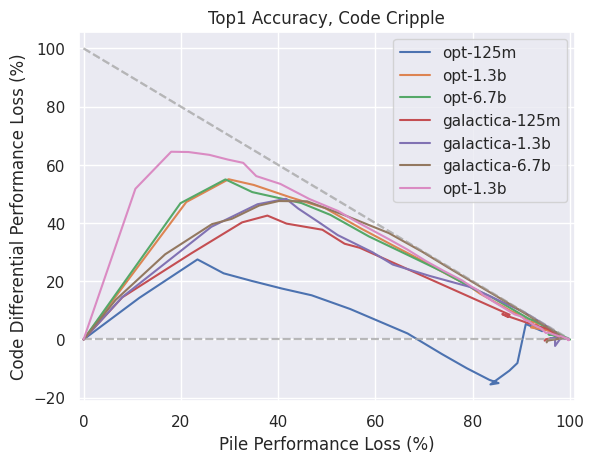

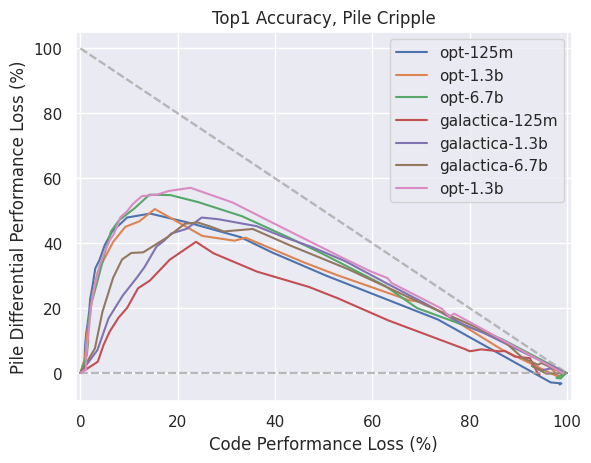

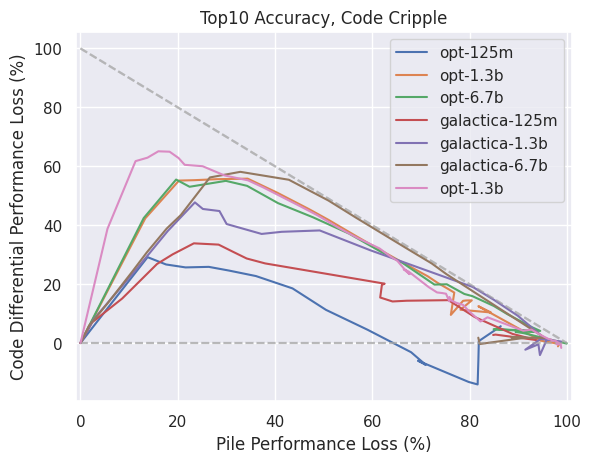

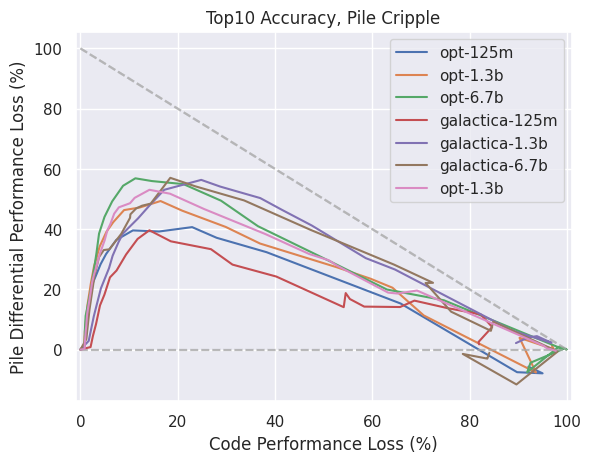

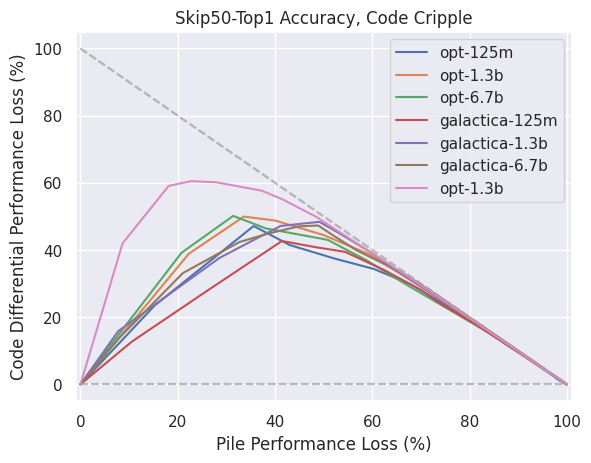

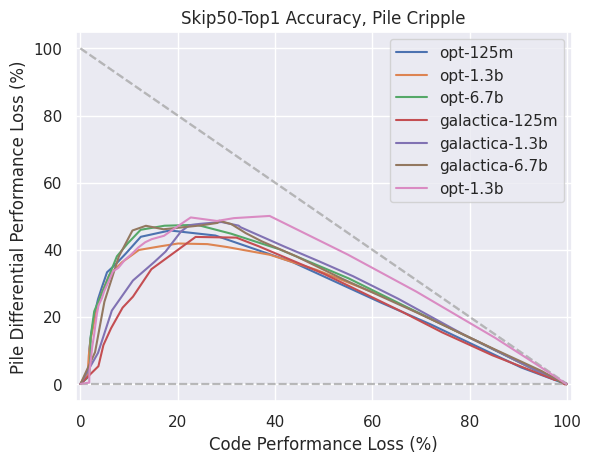

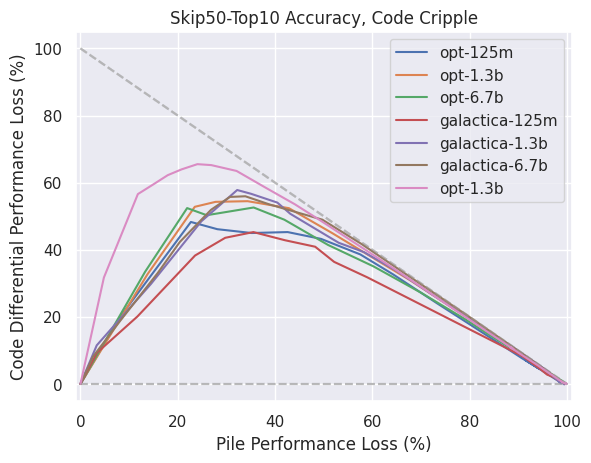

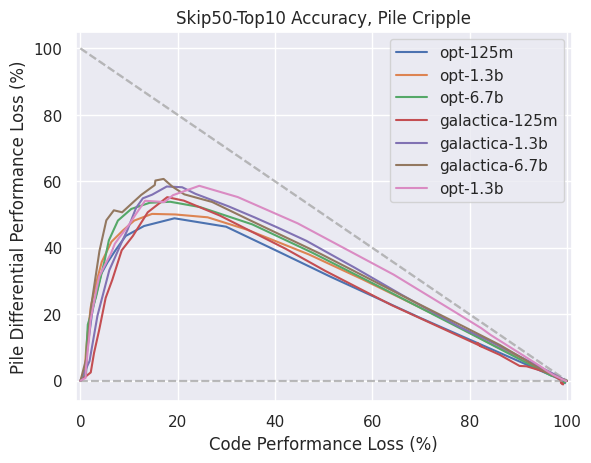

In [23]:
runs = [
    "https://wandb.ai/seperability/seperability-pile-code/runs/obg5k6jm", #opt 125m
    "https://wandb.ai/seperability/seperability-pile-code/runs/5e61eplg", #opt 125m
    "https://wandb.ai/seperability/seperability-pile-code/runs/hvymamky", #opt 1.3b
    "https://wandb.ai/seperability/seperability-pile-code/runs/1ix1b1aj", #opt 1.3b
    "https://wandb.ai/seperability/seperability-pile-code/runs/7q98xc4o", #opt 6.7b
    "https://wandb.ai/seperability/seperability-pile-code/runs/yiz8k8az", #opt 6.7b
    "https://wandb.ai/seperability/seperability-pile-code/runs/upkpdwk5", #Gal 125m
    "https://wandb.ai/seperability/seperability-pile-code/runs/8d3iylt9", #Gal 125m
    "https://wandb.ai/seperability/seperability-pile-code/runs/m6uuaz06", #Gal 1.3b
    "https://wandb.ai/seperability/seperability-pile-code/runs/dwwiizew", #Gal 1.3b
    "https://wandb.ai/seperability/seperability-pile-code/runs/iolc9z1l", #Gal 6.7b
    "https://wandb.ai/seperability/seperability-pile-code/runs/01b9nfvo", #Gal 6.7b
    "https://wandb.ai/seperability/seperability-pile-code/runs/fnvcnmtv", #Opt 1.3b codeless
    "https://wandb.ai/seperability/seperability-pile-code/runs/n4c1lo1o", #Opt 1.3b codeless 
]

plot_all_metrics(runs)
    

Top1
opt-125m 0.165
opt-125m 0.543
opt-1.3b 0.610
opt-1.3b 0.557
opt-6.7b 0.629
opt-6.7b 0.609
galactica-125m 0.465
galactica-125m 0.383
galactica-1.3b 0.513
galactica-1.3b 0.546
galactica-6.7b 0.572
galactica-6.7b 0.550
opt-1.3b 0.732
opt-1.3b 0.661
Top10
opt-125m 0.197
opt-125m 0.413
opt-1.3b 0.625
opt-1.3b 0.488
opt-6.7b 0.593
opt-6.7b 0.625
galactica-125m 0.356
galactica-125m 0.365
galactica-1.3b 0.538
galactica-1.3b 0.615
galactica-6.7b 0.648
galactica-6.7b 0.641
opt-1.3b 0.693
opt-1.3b 0.552
Skip50-Top1
opt-125m 0.522
opt-125m 0.536
opt-1.3b 0.582
opt-1.3b 0.534
opt-6.7b 0.571
opt-6.7b 0.574
galactica-125m 0.482
galactica-125m 0.488
galactica-1.3b 0.558
galactica-1.3b 0.545
galactica-6.7b 0.558
galactica-6.7b 0.568
opt-1.3b 0.740
opt-1.3b 0.640
Skip50-Top10
opt-125m 0.586
opt-125m 0.561
opt-1.3b 0.644
opt-1.3b 0.611
opt-6.7b 0.631
opt-6.7b 0.619
galactica-125m 0.519
galactica-125m 0.569
galactica-1.3b 0.632
galactica-1.3b 0.649
galactica-6.7b 0.644
galactica-6.7b 0.666
opt-1.3b 0

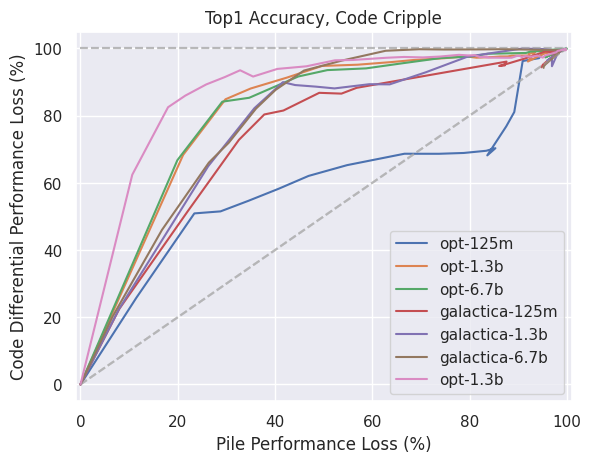

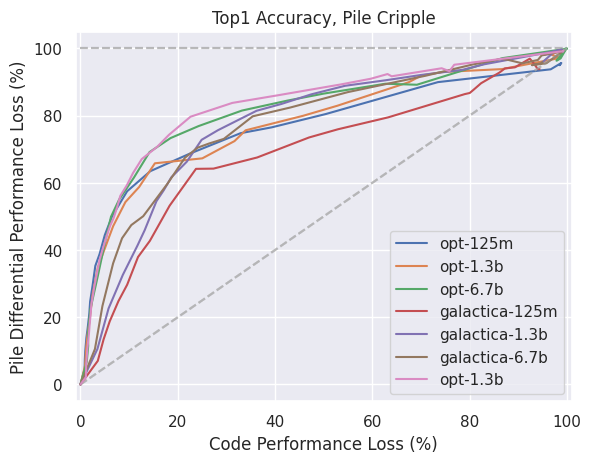

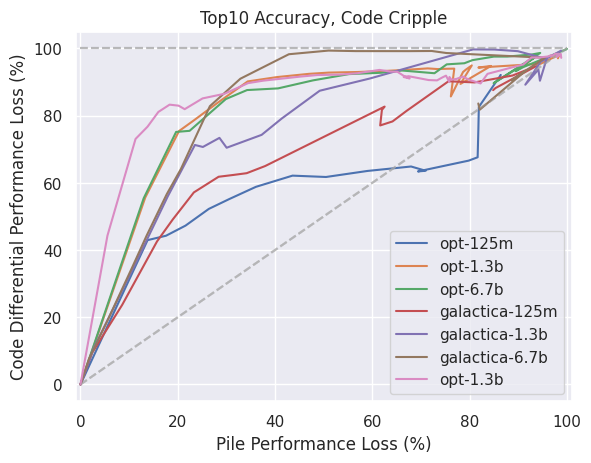

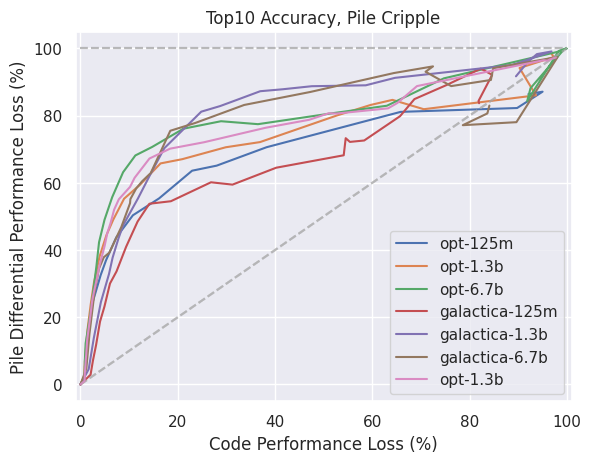

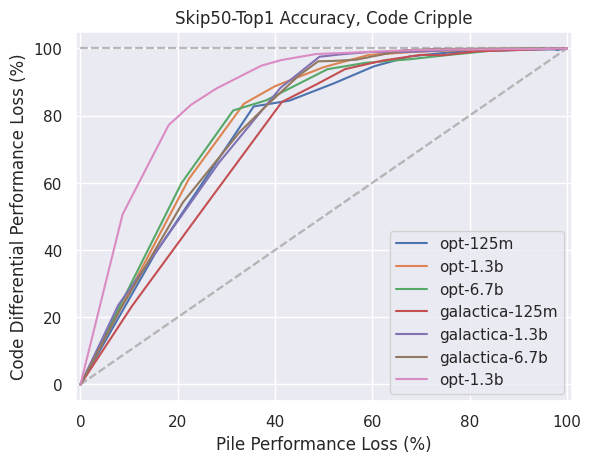

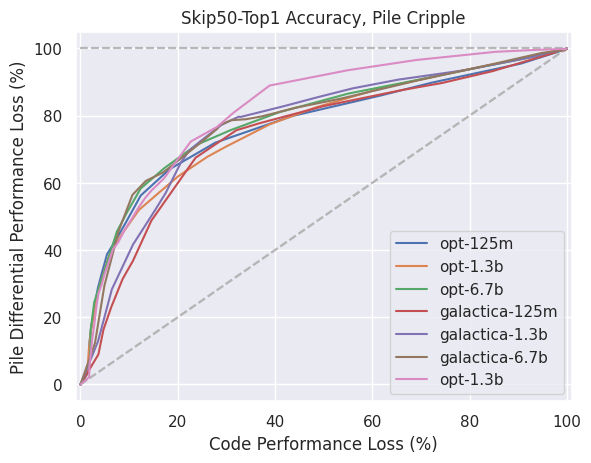

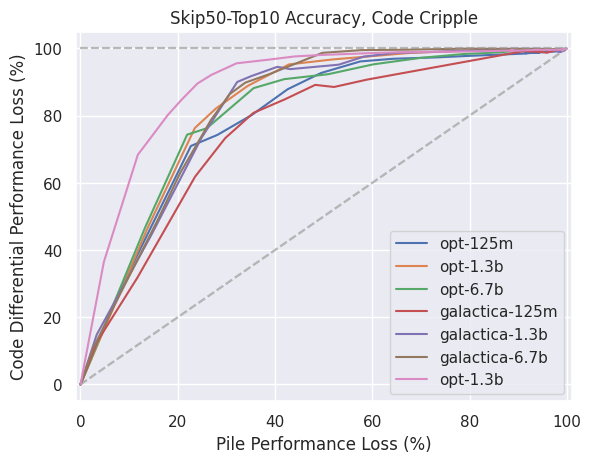

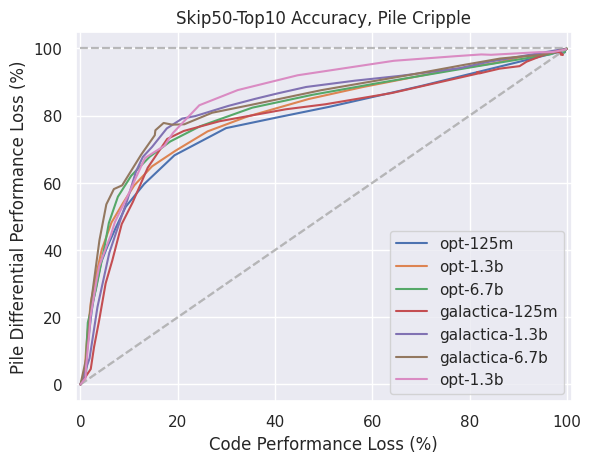

In [28]:

plot_all_metrics_2(runs)

Top1
opt-125m 0.108
opt-125m 0.013
opt-1.3b 0.171
opt-1.3b 0.167
opt-6.7b 0.235
opt-6.7b 0.240
Top10
opt-125m 0.094
opt-125m 0.015
opt-1.3b 0.153
opt-1.3b 0.151
opt-6.7b 0.221
opt-6.7b 0.178
Skip50-Top1
opt-125m 0.097
opt-125m 0.163
opt-1.3b 0.214
opt-1.3b 0.223
opt-6.7b 0.293
opt-6.7b 0.286
Skip50-Top10
opt-125m 0.029
opt-125m 0.168
opt-1.3b 0.163
opt-1.3b 0.319
opt-6.7b 0.274
opt-6.7b 0.334


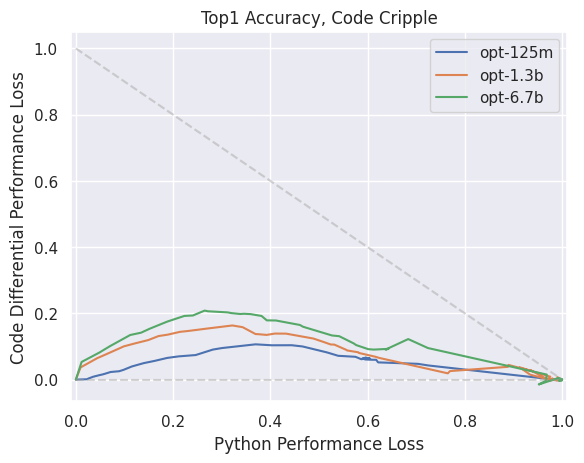

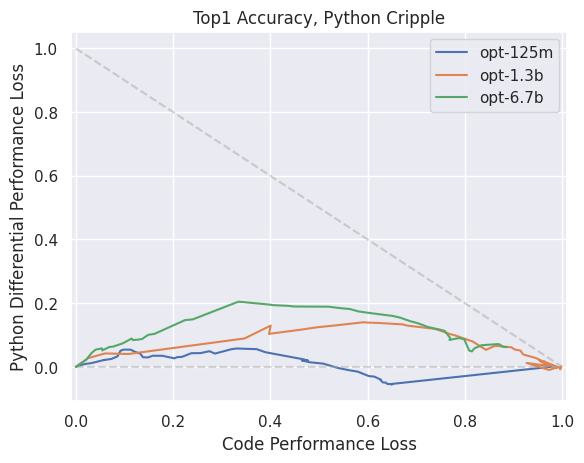

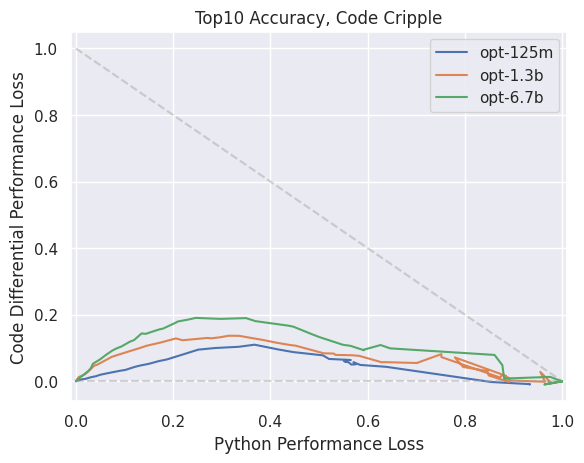

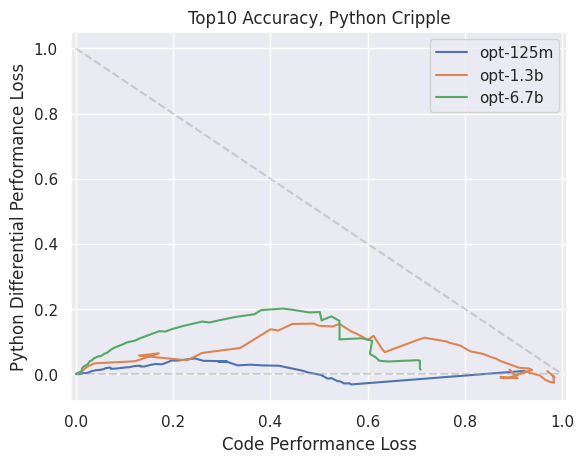

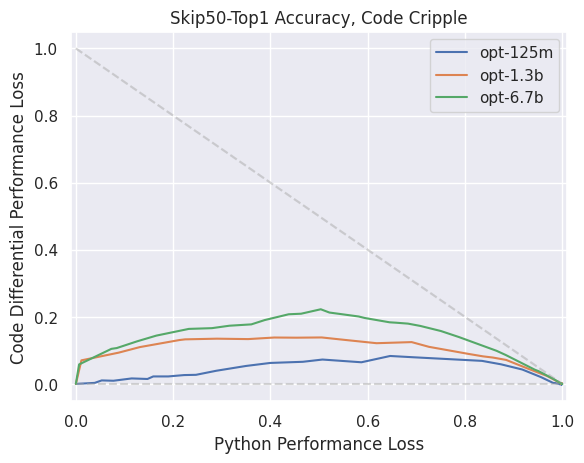

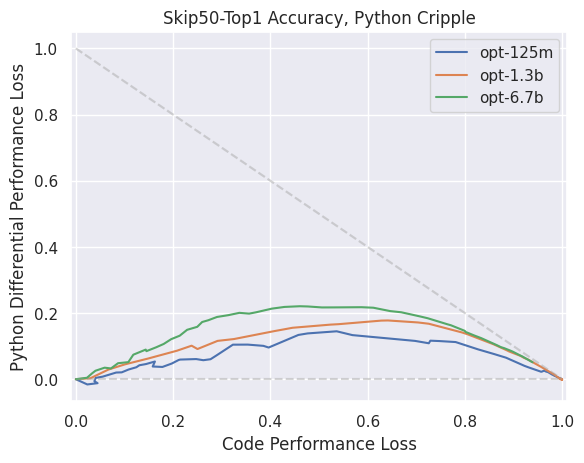

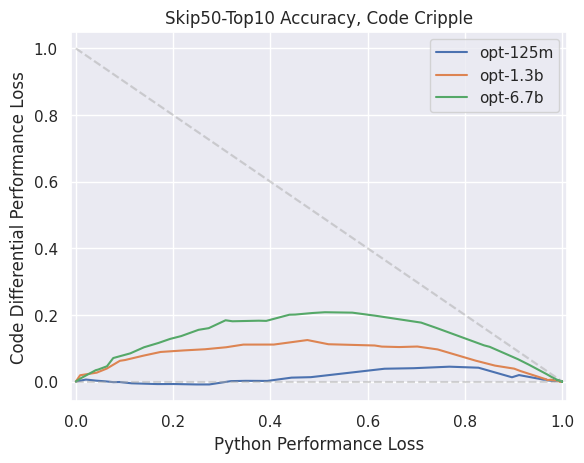

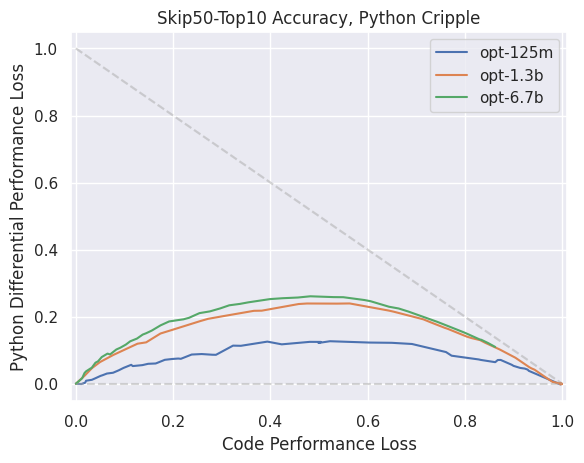

In [4]:
runs = [
    "https://wandb.ai/seperability/seperability-code-python/runs/3yufv3rs", # opt-125m
    "https://wandb.ai/seperability/seperability-code-python/runs/j40if0ty", # opt-125m
    "https://wandb.ai/seperability/seperability-code-python/runs/rswaqbp9", # opt-1.3b
    "https://wandb.ai/seperability/seperability-code-python/runs/50k83thu", # opt-1.3b
    "https://wandb.ai/seperability/seperability-code-python/runs/pfcrbj5q", # opt-6.7b
    "https://wandb.ai/seperability/seperability-code-python/runs/sz1d8p6b", # opt-6.7b
]

plot_all_metrics(runs)